In [10]:
! pip install transformers

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
<ipython-input-11-eb7b7cbaaa51>:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

Model loaded successfully and mapped to CPU.
              precision    recall  f1-score   support

        BERT       0.96      0.99      0.97       144
 DistilGPT-2       0.82      0.91      0.86       146
     Flan-T5       0.95      0.87      0.91       128
     GPT-Neo       0.83      0.83      0.83       138
         OPT       0.88      0.83      0.85       144

    accuracy                           0.89       700
   macro avg       0.89      0.88      0.89       700
weighted avg       0.89      0.89      0.89       700



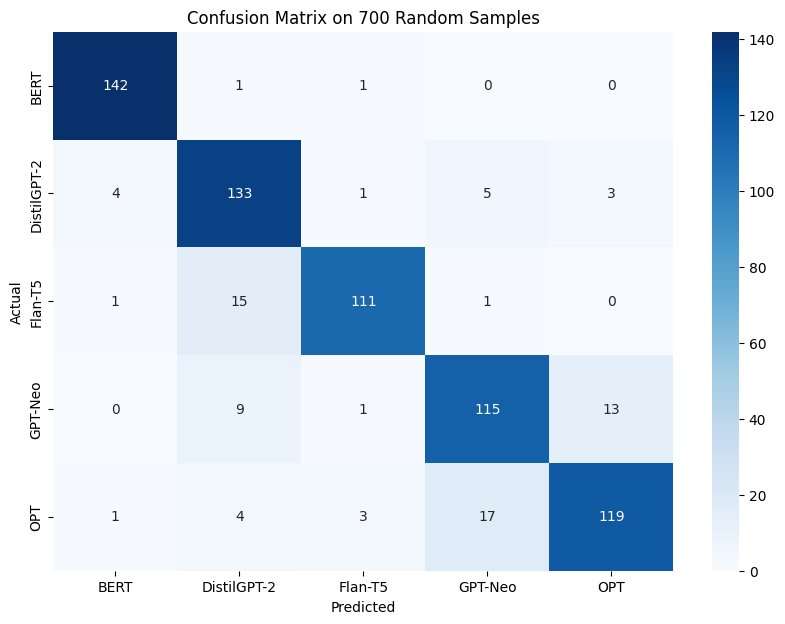

In [11]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# I am using CPU here as it is only a small set of 700
device = torch.device('cpu')

data = pd.read_csv('/content/output_check_parallel_750_final.csv') #please adjust the path of input csv file accordingly

data = data.dropna(subset=['Original Text', 'Completion'])

label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['Model'])

# Selecting 700 samples from the dataset for testing purposes
test_data = data.sample(n=700, random_state=42)

test_xi = test_data['Original Text']
test_xj = test_data['Completion']
test_labels = test_data['label']

class TextDataset(Dataset):
    def __init__(self, xi_texts, xj_texts, labels, tokenizer, max_len):
        self.xi_texts = xi_texts
        self.xj_texts = xj_texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.xi_texts)

    def __getitem__(self, idx):
        xi_text = self.xi_texts[idx]
        xj_text = self.xj_texts[idx]
        label = self.labels[idx]

        xi_inputs = self.tokenizer.encode_plus(xi_text, None, add_special_tokens=True, max_length=self.max_len,
                                               padding='max_length', truncation=True, return_tensors='pt')
        xj_inputs = self.tokenizer.encode_plus(xj_text, None, add_special_tokens=True, max_length=self.max_len,
                                               padding='max_length', truncation=True, return_tensors='pt')

        xi_input_ids = xi_inputs['input_ids'].squeeze()
        xi_attention_mask = xi_inputs['attention_mask'].squeeze()
        xj_input_ids = xj_inputs['input_ids'].squeeze()
        xj_attention_mask = xj_inputs['attention_mask'].squeeze()

        return {
            'xi_input_ids': xi_input_ids,
            'xi_attention_mask': xi_attention_mask,
            'xj_input_ids': xj_input_ids,
            'xj_attention_mask': xj_attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

batch_size = 32

test_dataset = TextDataset(test_xi.values, test_xj.values, test_labels.values, tokenizer, max_len=80)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

class LLMClassifier(nn.Module):
    def __init__(self, n_classes, dropout):
        super(LLMClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(self.bert.config.hidden_size * 2, n_classes)
        self.drop = nn.Dropout(p=dropout)

    def forward(self, xi_input_ids, xi_attention_mask, xj_input_ids, xj_attention_mask):
        xi_outputs = self.bert(input_ids=xi_input_ids, attention_mask=xi_attention_mask)
        xj_outputs = self.bert(input_ids=xj_input_ids, attention_mask=xj_attention_mask)

        combined_output = torch.cat((xi_outputs.pooler_output, xj_outputs.pooler_output), dim=1)
        output = self.drop(combined_output)
        return self.fc(output)

model = LLMClassifier(n_classes=len(label_encoder.classes_), dropout=0.31044108940585527)

# Loading the saved model
# model_path = os.path.join('saved_models', 'best_llm_classifier_model_xi_xj.pth')
model_path = '/content/best_llm_classifier_model_xi_xj-final.pth'#please adjust the saved model path as necessary

# Mapping the model to CPU and loading weights
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)

model = model.to(device)

print("Model loaded successfully and mapped to CPU.")

def test_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in data_loader:
            xi_input_ids = data['xi_input_ids'].to(device)
            xi_attention_mask = data['xi_attention_mask'].to(device)
            xj_input_ids = data['xj_input_ids'].to(device)
            xj_attention_mask = data['xj_attention_mask'].to(device)
            labels = data['label'].to(device)

            outputs = model(xi_input_ids, xi_attention_mask, xj_input_ids, xj_attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

test_labels, test_preds = test_model(model, test_loader, device)

print(classification_report(test_labels, test_preds, target_names=label_encoder.classes_))

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix on 700 Random Samples')
plt.show()
